# An example of fitting the synthetic nascent signal data

In [1]:
using CSV, DataFrames
using Plots; theme(:vibrant)
using RNAInferenceTool, StatsBase

## Import data and load SSA functions

In [2]:
# Import SSA code install delay SSA package at https://github.com/palmtree2013/DelaySSAToolkit.jl
include("delaytelegraphSSA.jl")
# Parameters 
τ = 0.5
tf = 20 
params = [1.0526,8.2034,57.989,0,0,τ,tf] # σ_off, σ_on, ρ_on, ρ_off, d, τ, SSA final time
L1 = 862; L = 3062; # L1 =  signal fluorescence 862 bp; L = total gene 3062 bp 

3062

## Generate synthetic SSA signal data

In [3]:
numofRun = 10000 # delay SSA sample size
djprob = construct_prob_delaytelegraph(params)
ens_prob = EnsembleProblem(djprob)
ens = solve(ens_prob, SSAStepper(), EnsembleThreads(), trajectories = numofRun);

## Check the distribution

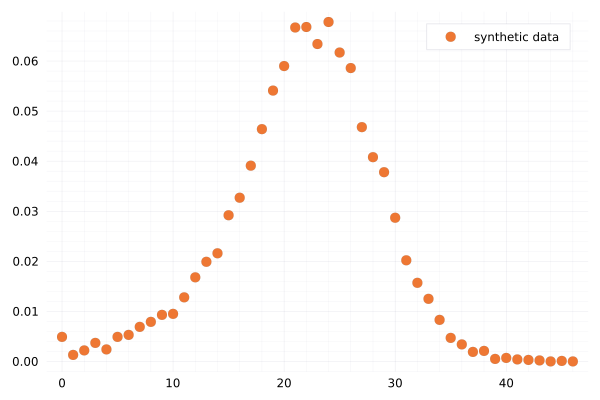

In [14]:
filter_pos_tf = [ens[i].channel[end][1] for i in eachindex(ens)]
res_ens = [signal_function.(filter_pos_tf[i], τ = τ, L1 = L1, L = L) for i in eachindex(filter_pos_tf)]
histo_synthetic = sum_with_non.(res_ens)
scatter(convert_histo(histo_synthetic), labels="synthetic data") # plot distribution

 # Inference

## load functions and set parameters

In [15]:
#For delay model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d, τ
SRange = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(0.0,0.0),(τ,τ)];

#For telegraph model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d
SRange_tele = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(1/τ,1/τ)];

Next, we set the data structure for optimization `OptimStruct`, which consists of the following elements:
1. data: default type is histogram data; the other supported type is to use probability distribution directly.
2. stage: `G1` or `G2`; where `G2` type data is inferred by setting G2 = G1*G1 (convolution).
3. dist: the distance function: Likelihood, Likelihood_fusion, Likelihood_rejection and other distance functions in Distances.jl package are supported.
4. model: telegraph model, delay telegraph model, and Poisson model are supported.
   
Keywords arguments:
1. infer_counts: Bool variable, `true` if the inferred histogram data is the number of count of the product (mature or bound Pol II), `false` if the histogram data is the normalized signal intensity.
2. L1, L2: if infer_counts is set `false` then L1 and L2 must be provided which represents the indices of the trapezoid signal function.

In [16]:
infer_struct = OptimStruct(histo_synthetic, G1(), Likelihood(), Delay(); infer_counts = false, L1 = 862, L2 =2200)
infer_struct_tele = OptimStruct(histo_synthetic, G1(), Likelihood(), Telegraph(); infer_counts = false, L1 = 862, L2 =2200)

OptimStruct{G1, Likelihood, Telegraph, Int64}([20.887390922199003, 21.126945838494407, 34.22863873064199, 23.1306709686713, 20.903918281571737, 15.626732226556843, 21.998713897912644, 21.8272120675011, 22.244305324000695, 23.715024689183355  …  14.45843174591407, 32.10388647967102, 24.603330342518092, 22.905287527750893, 24.137764446711095, 18.479683047586775, 13.833502159578552, 0.0, 30.277901291457653, 30.739839253719516], G1(), Likelihood(), Telegraph(), true, false, 862, 2200)

In [17]:
estimated_params, distributions = optim_function(SRange, infer_struct, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.60 secs, 160 evals, 96 steps, improv/step: 0.406 (last = 0.4062), fitness=33370.930486444
1.15 secs, 332 evals, 242 steps, improv/step: 0.393 (last = 0.3836), fitness=33286.286372206
1.66 secs, 523 evals, 438 steps, improv/step: 0.329 (last = 0.2500), fitness=33039.637084036
2.20 secs, 674 evals, 597 steps, improv/step: 0.293 (last = 0.1950), fitness=33039.637084036
2.70 secs, 866 evals, 806 steps, improv/step: 0.267 (last = 0.1914), fitness=33039.637084036
3.20 secs, 1066 evals, 1031 steps, improv/step: 0.257 (last = 0.2222), fitness=32977.480551712
3.70 secs, 1233 evals, 1220 steps, improv/step: 0.238 (last = 0.1323), fitness=32874.085830428
4.20 secs, 1419 evals, 1428 steps, improv/step: 0.228 (last = 0.1731), f

([0.8853077182587165, 7.267196249211093, 57.68823289049342, 0.0, 0.0, 0.5, 32746.277661184402], [0.004424334825200515 0.0049; 0.0019436706448767661 0.0013; … ; 1.010875929471481e-9 0.0; 4.453268661069516e-11 0.0])

In [18]:
estimated_params_tele, distributions_tele = optim_function(SRange_tele, infer_struct_tele, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 635 evals, 561 steps, improv/step: 0.298 (last = 0.2977), fitness=33477.793233190
1.00 secs, 1459 evals, 1466 steps, improv/step: 0.222 (last = 0.1757), fitness=33015.317019022
1.50 secs, 2240 evals, 2321 steps, improv/step: 0.202 (last = 0.1684), fitness=32802.673450321
2.00 secs, 2892 evals, 3022 steps, improv/step: 0.210 (last = 0.2368), fitness=32781.494339415
2.50 secs, 3579 evals, 3784 steps, improv/step: 0.204 (last = 0.1785), fitness=32779.438919967
3.00 secs, 4305 evals, 4587 steps, improv/step: 0.207 (last = 0.2204), fitness=32778.957564838
3.50 secs, 4999 evals, 5352 steps, improv/step: 0.206 (last = 0.1974), fitness=32778.951913434
4.00 secs, 5487 evals, 5893 steps, improv/step: 0.205 (last = 0

([0.3924994847725299, 3.1237234039186372, 57.832646258520334, 0.0, 2.0, 32778.95146682331], [0.0016658715119738932 0.0049; 0.002590664784974006 0.0013; … ; 9.540856476410526e-10 0.0; 4.205861099294469e-11 0.0])

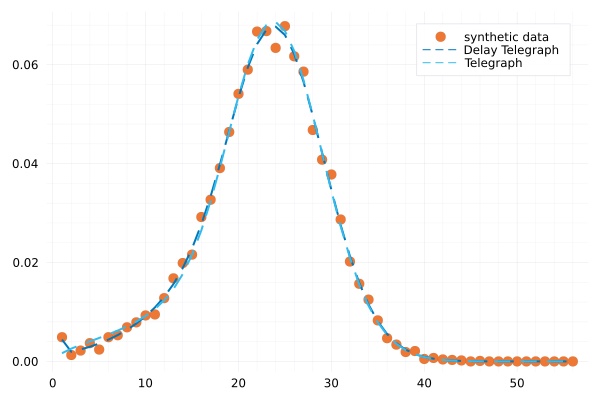

In [19]:
scatter(distributions[:,2],labels="synthetic data")
plot!([distributions[:,1] distributions_tele[:,1]],lines=(2, :dash),labels=["Delay Telegraph" "Telegraph"])

In [20]:
#Compare the paramters
DataFrame(True = params[1:3],Delay=estimated_params[1:3],Telegraph= estimated_params_tele[1:3])

,True,Delay,Telegraph
,Float64,Float64,Float64
1,1.0526,0.885308,0.392499
2,8.2034,7.2672,3.12372
3,57.989,57.6882,57.8326
